In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib
%matplotlib inline

In [2]:
mean = [[0, 0], [50, 40], [-10, 40]]
cov = [[[50, 20], [30, 40]], [[400, 500], [200, 400]], [[100, 20], [60, 40]]]
ms = 3

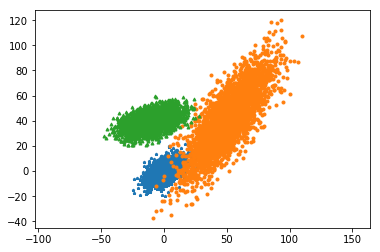

In [67]:
x0, y0 = np.random.multivariate_normal(mean[0], cov[0], 2500).T
x1, y1 = np.random.multivariate_normal(mean[1], cov[1], 3000).T
x2, y2 = np.random.multivariate_normal(mean[2], cov[2], 4500).T
plt.plot(x0, y0, '*', markersize = ms)
plt.plot(x1, y1, 'o', markersize = ms)
plt.plot(x2, y2, '^', markersize = ms)
plt.axis('equal')
plt.savefig("../output/origin.pdf")

In [26]:
X = np.c_[np.concatenate([x0, x1, x2]), np.concatenate([y0, y1, y2])]
Y = np.concatenate([[0 for i in xrange(len(x0))], [1 for i in xrange(len(x1))], [2 for i in xrange(len(x2))]])
num = len(X)
idx = np.arange(num)
np.random.shuffle(idx)
X = np.array([X[w] for w in idx])
Y = np.array([Y[w] for w in idx])
print X
print Y

[[ 68.22905263  39.32256902]
 [-14.87487712  43.17571916]
 [ -7.70816866 -10.45704534]
 ..., 
 [ 32.60888709  34.76356446]
 [ -1.45111188  -2.22574665]
 [ 73.79671328  64.76162394]]
[1 2 0 ..., 1 0 1]


(-55.097315027399468,
 119.64047804648179,
 -52.459961974421162,
 134.73140546614462)

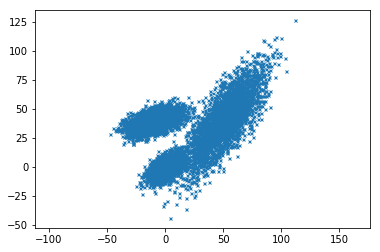

In [27]:
plt.plot(X[:,0], X[:,1], 'x', markersize = ms)
plt.axis('equal')

In [28]:
kernel = 3

In [29]:
def calc(x, m, v):
    return multivariate_normal.pdf(x, mean=m, cov=v)

In [30]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=kernel, random_state=0).fit(X)

label = kmeans.labels_
p = np.array([ \
    len( filter(lambda x: label[x] == k, range(num)) ) / float(num) \
    for k in xrange(kernel) ])
mu = kmeans.cluster_centers_
# p = np.array([1/3.0, 1/3.0, 1/3.0])
# mu = np.array([[0, 0], [1, 1], [-1, -1]])
si = [np.array([
        [10, 0 ],
        [0 , 10]
        ]) for k in xrange(kernel)]

In [31]:
for epoch in xrange(30):
    #    E step:
    #    --
    #    pp[i][j] : P(Y_j = k | X_j, \lambda_t) = p(Y_j = k) * Gaussian(X_j, \mu[k], \Sigma[k])
    #

    pp = np.array([[   p[k] * calc( X[j], mu[k], si[k] ) for j in xrange(num)  ] for k in xrange(kernel)])
    for j in xrange(num):
        temp = np.sum(pp[:,j])
        for k in xrange(kernel):
            pp[k][j] /= temp

    #    M step:
    #    --
    #    mu[i] : \mu[k]_{t+1} = \frac{ \sum_j_{P(Y_j=k | X_j,\lambda_t) * X[j] } }^{ \sum_j_{ P(Y_j = k | X_j, \lambda_t) } }

    mu = [  np.sum([ \
                pp[k][j] * X[j]
            for j in xrange(num) ], axis=0)
          / np.sum(pp[k]) \
        for k in xrange(kernel) ]
    
    si = [ np.sum( [ \
            pp[k][j] * np.mat(X[j] - mu[k]).T * np.mat(X[j]-mu[k]) \
                for j in xrange(num) ], axis=0) \
            / np.sum(pp[k]) \
        for k in xrange(kernel) ]
    
    p  = [ np.sum(pp[k]) / float(num)  for k in xrange(kernel) ]

    print "Epoch:", epoch
    print "-" * 30
    print p
    print
    print mu[0]
    print mu[1]
    print mu[2]
    print
    print si[0]
    print si[1]
    print si[2]
    print

Epoch: 0
------------------------------
[0.45049899272059102, 0.25020265833829852, 0.29929834894111046]

[ -9.7690214   40.01452064]
[ 54.53514625  46.56794692]
[ 4.30322113  0.98620254]

[[ 114.64829807   29.30556484]
 [  29.30556484   32.64855847]]
[[ 199.17624771  175.71348103]
 [ 175.71348103  340.56635343]]
[[ 148.76495377   48.87496441]
 [  48.87496441   61.33450046]]

Epoch: 1
------------------------------
[0.45050456392267296, 0.26756485428546656, 0.28193058179186048]

[ -9.76024287  40.05052308]
[ 52.90359957  43.94369688]
[ 2.74443902  0.61136278]

[[ 115.17695373   30.46522923]
 [  30.46522923   32.70974021]]
[[ 229.12177834  226.55163859]
 [ 226.55163859  426.13894021]]
[[ 112.00109558   41.26711247]
 [  41.26711247   50.72443127]]

Epoch: 2
------------------------------
[0.45046979689293348, 0.28158643755838131, 0.26794376554868532]

[ -9.76263531  40.05097592]
[ 51.65029073  42.05848845]
[ 1.43911623  0.32931995]

[[ 115.11695798   30.48680956]
 [  30.48680956   32.7193

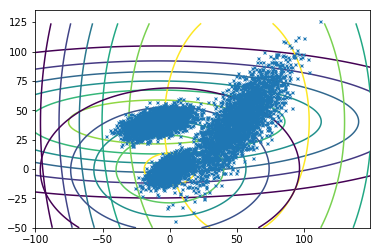

In [65]:
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

delta = 1
tx = np.arange(-100, 150, delta)
ty = np.arange(-50, 125, delta)
tX, tY = np.meshgrid(tx, ty)
Z0 = mlab.bivariate_normal(tX, tY, sigmax=si[0][0][0], sigmay=si[0][1][1],
                           mux=mu[0][0], muy=mu[0][1], sigmaxy=si[0][0][1])
Z1 = mlab.bivariate_normal(tX, tY, sigmax=si[1][0][0], sigmay=si[1][1][1],
                           mux=mu[1][0], muy=mu[1][1], sigmaxy=si[1][0][1])
Z2 = mlab.bivariate_normal(tX, tY, sigmax=si[2][0][0], sigmay=si[2][1][1],
                           mux=mu[2][0], muy=mu[2][1], sigmaxy=si[2][0][1])
plt.figure()
plt.plot(X[:,0], X[:,1], 'x', markersize = ms)
CS = plt.contour(tX, tY, Z0)
CS = plt.contour(tX, tY, Z1)
CS = plt.contour(tX, tY, Z2)
plt.savefig("../output/foo.pdf")